In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import sys
sys.path.append('../modules_for_nn_training')
from callbacks import CallbackHandler
from learner import Learner
from trainer import Trainer
from utility_callbacks import LossCallback

## Data

In [2]:
ys = np.linspace(0, 1, 5000)

In [3]:
def get_xs(ys):
    xs = 0.5 * (((2 * ys - 1.3) ** 3 + (2 * ys - 1.3) ** 2) * 6 + 0.6)
    noises = np.random.normal(loc=0, scale=0.2, size=len(ys))
    return xs + noises

In [4]:
xs = get_xs(ys)

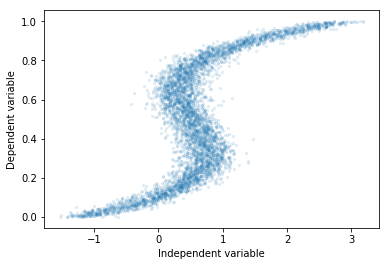

In [5]:
plt.scatter(xs, ys, s=5, alpha=0.1)
plt.xlabel('Independent variable'); plt.ylabel('Dependent variable')
plt.show()

In [6]:
xs, ys = xs.reshape(-1, 1), ys.reshape(-1, 1)

In [7]:
def train_test_split(xs, ys, train_prop):
    train_num = int(train_prop * len(xs))
    idxs = np.arange(len(xs))
    np.random.shuffle(idxs)
    train_idxs, valid_idxs = idxs[:train_num], idxs[train_num:]
    return (xs[train_idxs], ys[train_idxs]), (xs[valid_idxs], ys[valid_idxs])

In [8]:
(x_train, y_train), (x_valid, y_valid) = train_test_split(xs, ys, 0.8)

In [9]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((4000, 1), (4000, 1), (1000, 1), (1000, 1))

In [10]:
train_ds = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
valid_ds = TensorDataset(torch.from_numpy(x_valid), torch.from_numpy(y_valid))
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False)

## Model

In [11]:
class CDEstimator(nn.Module):
    
    """Conditional density estimator using neural networks."""
    
    def __init__(self, input_dim, output_dim, num_comps, num_hidden=1):
        
        super().__init__()
        
        self.num_comps = num_comps
        self.output_dim = output_dim
        
        self.get_mixing_coeffs = nn.Sequential(
            
            nn.Linear(input_dim, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_comps),
            nn.Softmax(dim=1)
        
        )
        
        self.get_means = nn.Sequential(
        
            nn.Linear(input_dim, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_comps * output_dim),
            
        )
        
        self.get_logvars = nn.Sequential(
        
            nn.Linear(input_dim, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_comps),
        
        )
        
    def forward(self, x):
        
        mixing_coeffs = self.get_mixing_coeffs(x)
        means = self.get_means(x).view((-1, self.num_comps, self.output_dim))
        variances = torch.exp(self.get_logvars(x)) 
        
        return {
            'mixing_coeffs' : mixing_coeffs,
            'means' : means,
            'variances' : variances
        }

In [12]:
def get_densities_under_gmm(mixing_coeffs, means, variances, t):
    
    probas = torch.zeros(t.size(0))
    
    num_components = mixing_coeffs.size(1)
    for j in range(num_components):
        probas += mixing_coeffs[:,j] * (
            1 / 
            (
                (2 * np.pi) ** (output_dim / 2) * (variances[:, j] ** 0.5) ** output_dim
            )
        ) * torch.exp(- torch.norm(t - means[:, j], dim=1) / (2 * variances[:, j]))
    
    return probas

In [13]:
def nll_loss(params, t):
    probas = get_densities_under_gmm(params['mixing_coeffs'], params['means'], params['variances'], t)
    return - torch.sum(torch.log(probas))

In [15]:
def get_model():
    nn = CDEstimator(1, 1, 3, 3)
    return nn, optim.Adam(nn.parameters(), lr=0.01)

In [ ]:
model, opt = get_model()
learn = Learner(train_dl, valid_dl, model, nll_loss, opt)

loss_cb = LossCallback()
cb_handler = CallbackHandler(cbs=[loss_cb])

trainer = Trainer(learn=learn, cb_handler=cb_handler)

trainer.find_lr(beta=0.98, final_value=10, num_itr=300)

In [307]:
trainer.set_lr(0.05)
trainer.train(num_epoch=50)

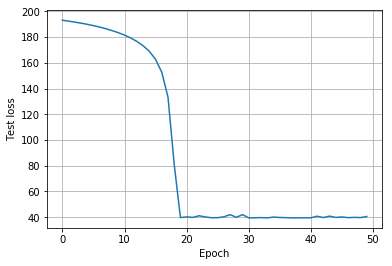

In [308]:
loss_cb.plot()
plt.show()

In [ ]:
model(torch.from_numpy(xs).float())